In [ ]:
# Data Exploration

In [22]:
import polars as pl
from darts import TimeSeries
from matplotlib.pyplot import legend

from src.energy_forecast.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, FEATURES

df_interim = pl.read_csv(INTERIM_DATA_DIR / "daily.csv")
df_processed = pl.read_csv(PROCESSED_DATA_DIR / "dataset_daily.csv")
df_interpolate = pl.read_csv(PROCESSED_DATA_DIR / "dataset_interpolate_daily.csv")
df_feat = pl.read_csv(PROCESSED_DATA_DIR / "dataset_daily_feat.csv")
df_missing_dates = pl.read_csv(REPORTS_DIR / "missing_dates_D.csv")

In [15]:
df_dh = pl.read_csv(INTERIM_DATA_DIR / "dh_daily.csv").drop(["sensor_id"]).with_columns(pl.lit("dh").alias("source"))
df_l = pl.read_csv(INTERIM_DATA_DIR / "legacy_daily.csv").with_columns(pl.lit("legacy").alias("source"))
df_k = pl.read_csv(INTERIM_DATA_DIR / "kinergy_daily.csv").drop(["avg_env_temp"]).with_columns(pl.lit("kinergy").alias("source"))
df_daily = pl.concat([df_dh, df_l, df_k])

## Meta Data

In [2]:
from src.energy_forecast.config import META_DIR

df_meta_l = pl.read_csv(META_DIR / "legacy_meta.csv").with_columns(pl.col("plz").str.strip_chars())
df_meta_dh = pl.read_csv(META_DIR / "dh_meta.csv")
df_lod = pl.read_csv(META_DIR / "dh_meta_lod.csv").rename(
            {"adresse": "address"})  # dh data with lod building data
df_meta_dh = df_meta_dh.join(df_lod, on=["address"]).drop(
            ["id_right", "postal_code_right", "city", "postal_code"])
df_meta_k = pl.read_csv(META_DIR / "kinergy_meta.csv", null_values="")
df_meta = pl.concat(
            [df_meta_l.cast({"plz": pl.Int64}).rename(
                {"qmbehfl": "heated_area", "anzlwhg": "anzahlwhg", "adresse": "address"}).with_columns(
                pl.lit("gas").alias("primary_energy"), pl.lit("legacy").alias("source")),
                df_meta_k.rename({"name": "address"}).with_columns(pl.lit("kinergy").alias("source")),
                df_meta_dh.rename({"Height (m)": "building_height", "Storeys Above Ground": "storeys_above_ground"}).with_columns(pl.lit("dh").alias("source")),
            ],
            how="diagonal")
df_meta = df_meta.with_columns(pl.when(pl.col("typ").is_null()).then(pl.lit("Mehrfamilienhaus")).otherwise(
                    pl.col("typ")).name.keep())
df_meta

id,GSM_ID,TP,Tag,Title,Type,s,m,CircuitType,CircuitNum,primary_energy,co2koeffizient,address,plz,ort,heated_area,anzahlwhg,source,orga,typ,complexity,complexity_score,begin,end,unit_code,renewable_energy_used,env_id,hash,has_pwh,pwh_type,netz_nummer,eco_u_id,data_provider_id,country,typ_right,min_vorlauf_temp,max_vorlauf_temp,primary_energy_right,Building ID,Creation Date,Country,Function,building_height,storeys_above_ground,ground_surface
str,i64,str,str,str,i64,i64,f64,str,i64,str,f64,str,i64,str,f64,i64,str,str,str,i64,f64,str,str,str,bool,str,str,bool,str,i64,str,str,str,str,i64,i64,str,str,str,str,str,f64,i64,f64
"""400095GVG""",400095,"""Gas""","""VG""","""Gaszähler""",10,0,1.0,"""NN""",0,"""gas""",2.26,"""Oktaviostr. 110-120""",22043,"""Hamburg""",13523.0,210,"""legacy""",null,"""Mehrfamilienhaus""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""400396GVG""",400396,"""GAS""","""VG""","""Gaszähler Kessel""",10,0,1.0,"""NN""",0,"""gas""",0.202,"""Ludewig-Meyn-Str.15""",24118,"""Kiel""",4191.0,155,"""legacy""",null,"""Mehrfamilienhaus""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""4007060VG""",400706,"""04200013_CYN_00_03""","""VG""","""Gaszähler 1""",10,0,1.0,"""K""",1,"""gas""",2.26,"""Süderelbering 2""",21149,"""Hamburg""",9205.0,0,"""legacy""",null,"""Mehrfamilienhaus""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""400926GVG""",400926,"""Gas""","""VG""","""Gaszähler""",10,0,1.0,"""NN""",0,"""gas""",2.26,"""Schellingstraße 21/23""",95447,"""Bayreuth""",2488.0,60,"""legacy""",null,"""Mehrfamilienhaus""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""400819GVG""",400819,"""Gas""","""VG""","""Gaszähler""",10,0,1.0,"""NN""",0,"""gas""",2.26,"""Burgfeldstraße 41""",23795,"""Bad Segeberg""",622.0,0,"""legacy""",null,"""Mehrfamilienhaus""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""a141529b-2b91-4c85-ae9f-907901…",null,null,null,null,null,null,null,null,null,"""district heating""",null,"""Ulzburger Straße 457""",22846,"""Norderstedt""",1029.272643,null,"""dh""",null,"""Mehrfamilienhaus""",null,null,null,null,"""kwh""",null,null,null,null,null,null,"""a141529b-2b91-4c85-ae9f-907901…","""6cbc3fb6iyoz""","""DE""","""Mehrfamilienhaus""",75,90,"""district heating""","""DESHPDHK0006FU8b""","""2023-08-15""","""Deutschland""","""31001_1010""",10.031,3,320.653675
"""bc098a2e-0cc7-4f01-b6ad-9d647a…",null,null,null,null,null,null,null,null,null,"""district heating""",null,"""Ulzburger Straße 459 A""",22846,"""Norderstedt""",1279.979781,null,"""dh""",null,"""Mehrfamilienhaus""",null,null,null,null,"""kwh""",null,null,null,null,null,null,"""bc098a2e-0cc7-4f01-b6ad-9d647a…","""cec5ec7cspn2""","""DE""","""Mehrfamilienhaus""",75,90,"""district heating""","""DESHPDHK0006FU68""","""2023-08-15""","""Deutschland""","""31001_1010""",13.105,4,305.222191
"""8e9b1544-434e-44a7-8049-8f2e4b…",null,null,null,null,null,null,null,null,null,"""district heating""",null,"""Ulzburger Straße 461""",22846,"""Norderstedt""",1414.36575,null,"""dh""",null,"""Mehrfamilienhaus""",null,null,null,null,"""kwh""",null,null,null,null,null,null,"""8e9b1544-434e-44a7-8049-8f2e4b…","""f1af853af3qs""","""DE""","""Mehrfamilienhaus""",75,90,"""district heating""","""DESHPDHK0006FU6t""","""2023-08-15""","""Deutschland""","""31001_1010""",13.537,4,326.504615


## Data Coutnts

In [ ]:
import plotly.express as px
px.pie(df_meta.group_by("typ").agg(pl.len()), values="len", names="typ", labels=["residential building", "school", "student housing", "museum", "social housing"])

In [ ]:
df_type = df_meta.group_by("typ").agg(pl.len()).sort("len", descending=True)
df_type

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.pie(df_type["len"], labels=["residential building: 131", "school: 11", "student housing: 4", "museum: 2", "social housing: 1"],
       colors=["green", "red", "yellow", "orange", "blue"], textprops={'fontsize': 16})

In [ ]:
from src.energy_forecast.config import FIGURES_DIR
# Assuming df_type["len"] contains your values [131, 11, 4, 2, 1]
fig, ax = plt.subplots(figsize=(14, 8))

# Create the pie chart but store the text objects
wedges, texts = ax.pie(
    df_type["len"],
    labels=["residential building: 131", "school: 11", "student housing: 4", "museum: 2", "social housing: 1"],
    colors=["green", "red", "yellow", "orange", "blue"],
    textprops={'fontsize': 24},
    radius=0.7
)

# Adjust the position of the social housing label (the last one)
social_housing_text = texts[-1]  # Get the last text object
current_position = social_housing_text.get_position()
# Move it higher by adjusting the y-coordinate (increase the value to move it higher)
social_housing_text.set_position((current_position[0], current_position[1]+0.05))

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()

plt.savefig(FIGURES_DIR / "types_pie_chart.png", dpi=300)

In [ ]:
from src.energy_forecast.config import FIGURES_DIR
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=["social housing", "museum", "student housing", "school", "residential building"],
                             values=df_type["len"])])
fig.update_traces(textinfo='value', textfont_size=20)
fig.update_layout(font=dict(
        family="Courier New, monospace",
        size=16,
        color="RebeccaPurple"
    )
)
fig.show()


In [ ]:
fig.write_image(FIGURES_DIR / "type_buildings_pie.png")

In [ ]:
df_meta.filter(pl.col("primary_energy")=="gas").group_by("source").agg(pl.len())

In [ ]:
df_interim.group_by("source").agg(pl.len())

In [ ]:
df_interim.filter(pl.col("primary_energy")=="district heating").group_by("source").agg(pl.len())

In [ ]:
df_processed.group_by("source").agg(pl.len())

In [ ]:
df_processed.join(df_meta.select(["primary_energy", "id"]), on="id").filter(pl.col("primary_energy")=="district heating").group_by("source").agg(pl.len())

In [ ]:
df_interpolate.join(df_meta.select(["primary_energy", "id"]), on="id").filter(pl.col("primary_energy")=="district heating").group_by("source").agg(pl.len())


## Data Processing

In [ ]:
raw_series = TimeSeries.from_dataframe(df_interim.filter(pl.col("id") == "10af300b-a270-4e41-928d-e4048b2fdf00"),
                                   time_col="date",
                                   value_cols="diff",
                                   fill_missing_dates=True)
raw_series.plot()

In [ ]:
p_series = TimeSeries.from_dataframe(df_processed.filter(pl.col("id") == "10af300b-a270-4e41-928d-e4048b2fdf00"),
                                   time_col="datetime",
                                   value_cols="diff",
                                   fill_missing_dates=True)
p_series.plot()

In [ ]:
raw_series.plot(label="raw")
p_series.plot(label="processed")

In [ ]:
df_interpolate.group_by("id").agg(pl.len()).sort(by="id")

In [ ]:
raw_series.plot(label="raw")
p_series.plot(label="processed")
cut_series = list()
for i in range(5):
    c_series =  TimeSeries.from_dataframe(df_interpolate.filter(pl.col("id") == f"10af300b-a270-4e41-928d-e4048b2fdf00-{i}"),
                                   time_col="datetime",
                                   value_cols="diff",
                                   fill_missing_dates=True)
    cut_series.append(c_series)
    c_series.plot(label=f"part {i}")

## Missing Dates

In [23]:
df_missing_dates.sort(by="len")

id,len,n,per,start_date,end_date
str,i64,i64,f64,str,str
"""400350GVG""",1,1,50.0,"""2021-06-30T00:00:00.000000""","""2021-06-30T00:00:00.000000"""
"""400974GVG""",75,75,98.684211,"""2021-08-20T00:00:00.000000""","""2021-11-02T00:00:00.000000"""
"""578e031d-e014-11eb-9d61-02b402…",92,92,98.924731,"""2023-06-19T00:00:00.000000""","""2023-09-18T00:00:00.000000"""
"""400926GVG""",117,117,99.152542,"""2021-06-10T00:00:00.000000""","""2021-10-04T00:00:00.000000"""
"""400961GVG""",133,132,98.507463,"""2021-11-04T00:00:00.000000""","""2022-03-16T00:00:00.000000"""
…,…,…,…,…,…
"""400099PVG""",1680,1636,97.323022,"""2017-08-17T00:00:00.000000""","""2022-03-23T00:00:00.000000"""
"""400103PVG""",1682,1676,99.584076,"""2017-08-08T00:00:00.000000""","""2022-03-16T00:00:00.000000"""
"""400090PVG""",1731,1719,99.249423,"""2017-06-28T00:00:00.000000""","""2022-03-24T00:00:00.000000"""


In [39]:
import plotly.express as px
from src.energy_forecast.config import FIGURES_DIR

df_plot_missing_dates = pl.concat([df_missing_dates.sort(by="len", descending=True).select(["id", "len", "per"]).with_columns(pl.lit("missing").alias("type")),
           df_missing_dates.sort(by="per").select(["id", "n", "per"]).rename({"n": "len"}).with_columns(pl.lit("whole").alias("type"))], how="vertical")
df_plot_missing_dates = df_plot_missing_dates.rename({"len": "Count", "id": "ID", "type":"Type"})
fig = px.bar(df_plot_missing_dates, x="ID", y="Count", color="Type", width=900, height=550)
fig.update_layout(legend=dict(font=dict(size=16)), font=dict(size=16))
fig.update_xaxes(showticklabels=False)
fig.update_layout(
    template='plotly'
)
fig.show()
# fig.write_image(FIGURES_DIR / "missing_dates.png")
fig.write_image(FIGURES_DIR / "missing_dates.pdf")

## Visualize all Sensors

In [ ]:
import plotly.graph_objs as go

# source = "legacy"
source = "all"
# df =  df_interpolate.filter(pl.col("source") == source).sort("id")
df = df_interpolate
df_min_max_dates = df.group_by(["id"]).agg(
    [pl.col("datetime").min().alias("min_date"),
     pl.col("datetime").max().alias("max_date"),
     pl.len().alias("days")
     ]
)

fig = go.Figure()
for (start, end, value, days) in zip(df_min_max_dates["min_date"], df_min_max_dates["max_date"],
                                     df_min_max_dates["id"], df_min_max_dates["days"]):
    # name = f"{start} to {end}"
    name = days
    fig.add_trace(go.Scatter(x=[start, end], y=[value, value],
                             mode='lines', name=name))

fig.show()
fig.write_html(f"../reports/figures/gaszähler_start_end_datum_{source}.html")
fig.write_image("../reports/figures/gaszähler_start_end_datum.png")

In [ ]:
df_interpolate.group_by("id").agg(pl.len())

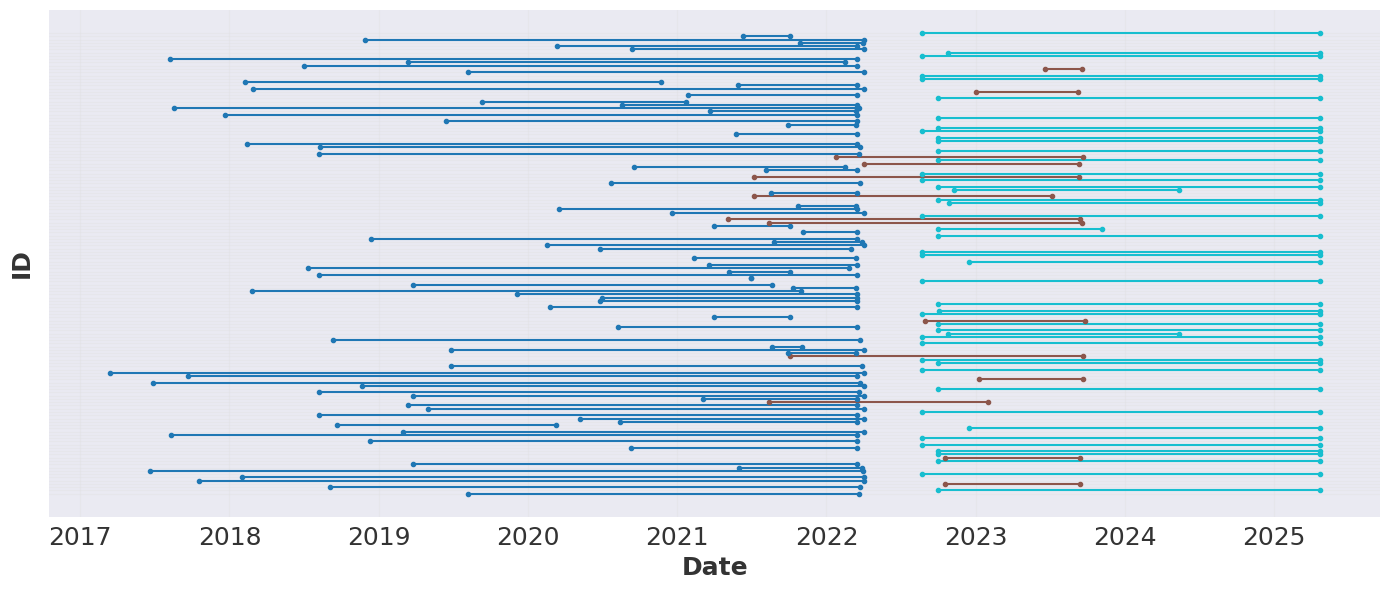

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import os

# Data preparation (same as original)
df = df_daily
df_min_max_dates = df.group_by(["id"]).agg(
    [pl.col("datetime").min().alias("min_date"),
     pl.col("datetime").max().alias("max_date"),
     pl.len().alias("days"),
     pl.col("source").first().alias("source")
     ]
)

# Get unique sources and create color map
unique_sources = df_min_max_dates["source"].unique().to_list()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_sources)))
source_color_map = dict(zip(unique_sources, colors))

# Count lines per source
source_counts = df_min_max_dates.group_by("source").len().to_dict()
source_count_map = dict(zip(source_counts["source"], source_counts["len"]))

# Keep track of sources already added to legend
sources_in_legend = set()

# Create matplotlib figure
fig, ax = plt.subplots(figsize=(14, 6))

# Plot lines for each id
for i, (start, end, value, days, source) in enumerate(zip(
    df_min_max_dates["min_date"],
    df_min_max_dates["max_date"],
    df_min_max_dates["id"],
    df_min_max_dates["days"],
    df_min_max_dates["source"]
)):
    # Convert string datetime to datetime objects
    if isinstance(start, str):
        # Parse the ISO format string, handling nanoseconds
        start = datetime.fromisoformat(start.replace('T', ' ').split('.')[0])
        end = datetime.fromisoformat(end.replace('T', ' ').split('.')[0])

    label=None
    if source not in sources_in_legend:
        count = source_count_map[source]
        label = f"{source} ({count})"
        sources_in_legend.add(source)

    # Plot horizontal line from start to end date
    ax.plot([start, end], [value, value],
            label=label,
            linewidth=1.5,
            marker='o',
            markersize=3,
            color=source_color_map[source])

# Formatting
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('ID', fontsize=18)
# ax.set_title('Gas Meter Start/End Dates', fontsize=14, fontweight='bold')

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Remove y-axis labels
ax.set_yticklabels([])

# Format x-axis to show only years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Increase font size for x-axis tick labels
ax.tick_params(axis='x', labelsize=18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')

# Add legend
# ax.legend(title='Days', bbox_to_anchor=(1.05, 1), loc='upper left')
# Add legend showing source colors
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)

# Grid for better readability
ax.grid(True, alpha=0.3)

# Tight layout to prevent label cutoff
plt.tight_layout()

# Create output directory if it doesn't exist
os.makedirs("../reports/figures", exist_ok=True)

# Save figure
plt.savefig("../reports/figures/gaszähler_start_end_datum.png",
            dpi=300,
            bbox_inches='tight',
            facecolor='white')

plt.savefig(FIGURES_DIR / "gaszähler_start_end_datum.pdf", format="pdf", dpi=600, bbox_inches='tight', facecolor='white')
# Show plot
plt.show()

In [ ]:
import plotly.graph_objs as go

source = "legacy"
df =  df_interpolate.sort("id")
df_min_max_dates = df.group_by(["id"]).agg(
    [pl.col("datetime").min().alias("min_date"),
     pl.col("datetime").max().alias("max_date"),
     pl.len().alias("days")
     ]
)

fig = go.Figure()
for (start, end, value, days) in zip(df_min_max_dates["min_date"], df_min_max_dates["max_date"],
                                     df_min_max_dates["id"], df_min_max_dates["days"]):
    # name = f"{start} to {end}"
    name = days
    fig.add_trace(go.Scatter(x=[start, end], y=[value, value],
                             mode='lines', name=name))

fig.show()
fig.write_html(f"../reports/figures/gaszähler_start_end_datum.html")
# fig.write_image("../reports/figures/gaszähler_start_end_datum.png")

## Feature

In [ ]:
df_feat.columns

In [ ]:
len(df_feat)

In [ ]:
len(df_feat.filter(~pl.col("anzahlwhg").is_null()))

In [ ]:
df_meta.group_by("typ").agg(pl.len())

## Feature Correlation

In [ ]:
features = list(set(FEATURES) - {"diff_t-1", "ground_surface", "building_height", "storeys_above_ground", "heated_area", "anzahlwhg", "daily_avg"})
df_feat[features].describe()

In [ ]:
fig = px.imshow(df_feat[features].drop_nulls(["snow", "tsun", "wpgt"]).to_pandas().corr())
fig.show()

In [ ]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

df = df_feat[features].drop_nulls(["snow", "tsun", "wpgt"]).to_pandas()

enc = OneHotEncoder()
cat_features = ["primary_energy"]  # categorical features we want
enc = enc.fit(df[cat_features])
cat_features_names = enc.get_feature_names_out()
X_enc = DataFrame(enc.transform(df[cat_features]).toarray(), columns=cat_features_names)
df = df.drop(columns=cat_features)
df = pd.concat([df, X_enc], axis=1)

corr = df.corr()

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            annot=True)

In [ ]:
## Feature Correlation
features_ha = list(
    set(FEATURES) - {"diff_t-1", "ground_surface", "building_height", "storeys_above_ground", "daily_avg"})
df = df_feat[features_ha].drop_nulls(["snow", "tsun", "wpgt", "anzahlwhg", "heated_area"]).to_pandas()

enc = OneHotEncoder()
cat_features = ["primary_energy"]  # categorical features we want
enc = enc.fit(df[cat_features])
cat_features_names = enc.get_feature_names_out()
X_enc = DataFrame(enc.transform(df[cat_features]).toarray(), columns=cat_features_names)
df = df.drop(columns=cat_features)
df = pd.concat([df, X_enc], axis=1)

corr = df.corr()

f, ax = plt.subplots(figsize=(17, 12))
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax,
            annot=True)